In [1]:
import pints
import pints.toy as toy
import pints.plot

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

import numpy as np
import matplotlib.pyplot as plt
import GPy
from GPy import kern as kern

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import string
from itertools import product

## Specifying model

In [2]:
# Load problem from predefined ones
model = emupints.Problems.LogisticModel
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([ -1.40655874,  -7.39489169,  -8.661145  , -12.52809325,
        10.72035499])

In [3]:
# take all the required variables from the problem
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
log_prior = problem['log_prior']
log_posterior = problem['log_posterior']
real_parameters = problem['parameters']
pints_problem = problem['problem']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

# Apply CMA-ES

In [4]:
# CMA-es
score = pints.SumOfSquaresError(pints_problem)
x0 = bounds.sample(1)[0]

found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      1283376    0:00.1
1     12     627591.2   0:00.1
2     18     516621.9   0:00.1
3     24     516621.9   0:00.1
20    126    513921.1   0:00.1
40    246    499279.4   0:00.1
60    366    115137.7   0:00.1
80    486    114850.7   0:00.2
100   606    114849.4   0:00.2
120   726    114849.4   0:00.2
140   846    114849.4   0:00.2
160   966    114849.4   0:00.2
180   1086   114849.4   0:00.3
200   1206   114849.4   0:00.3
220   1326   114849.4   0:00.4
240   1446   114849.4   0:00.4
260   1566   114849.4   0:00.4
280   1686   114849.4   0:00.5
300   1806   114849.4   0:00.5
320   1926   114849.4   0:00.6
340   2046   114849.4   0:00.6
360   2166   114849.4   0:00.6
380   2286   114849.4   0:00.7
400   2406   114849.4   0:00.7
420   2526   114849.4   0:00.7
440   2646   114849.4   0:00.7
460   2766   114849.4   0:00

# Use found parameters to sample trianing data

In [5]:
# training size
# use bigger training size for NNs because speed stays the same
train_size = 500
test_size = 1000
sampling_std = 0.05 * found_parameters # take 5% around found parameters std

def normal_sampling(size, mean, std):
    return mean + np.random.randn(*size) * std

# create data for training and testing
# genera example using normal distribution around parametrs
train_X = normal_sampling((train_size, n_parameters), found_parameters, sampling_std)
train_y = np.apply_along_axis(log_likelihood, 1, train_X)

# if provide validation data to keras model also need to normalize it 
test_X = normal_sampling((test_size, n_parameters), found_parameters, sampling_std)
test_y = np.apply_along_axis(log_likelihood, 1, test_X)

## Creating GP and selecting kernel

In [6]:
emu = emupints.GPEmulator(log_likelihood,
                          train_X,
                          train_y,
                          input_scaler=StandardScaler(),
                         )

In [7]:
n_parameters = emu.n_parameters()


kernels = [
    kern.Linear(n_parameters),
    kern.RBF(n_parameters),
    kern.RatQuad(n_parameters),
    kern.MLP(n_parameters),
    kern.Matern52(n_parameters),
    kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
    kern.Matern52(n_parameters) + kern.RBF(n_parameters),
    kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
    kern.MLP(n_parameters) + kern.Matern52(n_parameters) + kern.RatQuad(n_parameters),
]

kernel_names = [
    'Linear',
    'RBF',
    'RatQuad',
    'MLP',
    'Matern',
    'RatQuad + RBF',
    'Matern52 + RBF',
    'RatQuad + RBF',
    'MLP + Matern + RatQuad'
]

# kernels that have been optimized for input data
trained_kernels = []

# possible optimizers: 
# ‘scg’, ‘lbfgs’, ‘tnc’
# can specify max number of iterations using max_iters
optimizer = "lbfgs"
max_iters = 500
emu.set_parameters(optimizer = optimizer)

In [8]:
# when the output data is normalized values of variance should be small
# hence ignore any kernel that has a subkernel 
# (i.e kernel that is a part of sum/product) 
# with variance > 1000
# set avoid_overfitting to False to stop this effect
avoid_overfitting = False
variance_threshold = 1000

# store prediction time for comparison
likelihood_time = %timeit -o log_likelihood(real_parameters)
likelihood_time = likelihood_time.average

24.4 µs ± 1.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
marginal_likelihoods = []
prediction_times = []

for kernel, kernel_name in zip(kernels, kernel_names):
    emu.set_parameters(kernel = kernel)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = max_iters, messages = False)

    trained_kernel = emu.get_trained_kern()
    trained_kernels.append(trained_kernel)

    # time prediction
    emu_time =  %timeit -o emu(real_parameters)
    prediction_times.append(emu_time.average)

    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(kernel_name, ml))

301 µs ± 7.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Linear: -708.09
345 µs ± 9.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RBF: 3953.52


 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:676: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:681: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:688: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:690: RuntimeWarning:invalid value encountered in multiply


439 µs ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad: 3940.10
585 µs ± 82.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MLP: 3919.89
425 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Matern: 3538.11
810 µs ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad + RBF: 3954.01
715 µs ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Matern52 + RBF: 3953.62
783 µs ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad + RBF: 3954.01
1.08 ms ± 74.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MLP + Matern + RatQuad: 3954.03


In [10]:
best_kernel = None
best_score = -1 << 31
best_time = -1 << 31

# find kernel with highest log marginal likelihood
for kernel, score, emu_time in zip(trained_kernels, marginal_likelihoods, prediction_times):
    # ignore any overfitting kernel
    if avoid_overfitting and emutils.has_high_variance(kernel, threshold = variance_threshold):
        continue
    
    # avoid kernels that don't provide 5x speed up
    if 5 * emu_time > likelihood_time:
        continue

    if score > best_score:
        best_kernel = kernel
        best_time = emu_time
        best_score = best_score
        
print('Prediction time: ', best_time)
best_kernel

Prediction time:  -2147483648


In [11]:
emu.set_parameters(kernel = kernels[1])
emu.fit(optimize = False, normalizer = True)
emu.optimize(max_iters = max_iters, messages = True)    

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s17  010  -3.953124e+03   2.416256e-01 
    00s19  011  -3.953124e+03   2.416256e-01 

 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s76  046  -3.953124e+03   2.416256e-01 
Runtime:     00s76
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'



In [12]:
emu.get_gp()

GP_regression.,value,constraints,priors
rbf.variance,124112.59541952946,+ve,
rbf.lengthscale,18.423981886333493,+ve,
Gaussian_noise.variance,1.596176783359349e-11,+ve,


# Likelihood metrics

In [13]:
emu_time = %timeit -r 50 -o emu(real_parameters)
print("Emulator prediction time (micro-seconds): {:5f}".format(emu_time.average * 1000000))

399 µs ± 44.8 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
Emulator prediction time (micro-seconds): 399.254467


In [14]:
likelihood_time = %timeit -r 50 -o log_likelihood(real_parameters)
print("Likelihood prediction time (micro-seconds): {:5f}".format(likelihood_time.average * 1000000))

25.9 µs ± 1.95 µs per loop (mean ± std. dev. of 50 runs, 10000 loops each)
Likelihood prediction time (micro-seconds): 25.899745


In [15]:
pred_y = np.apply_along_axis(emu, 1, test_X)
print("Mean absolute error (mae): {:.5f}".format(emumet.mae(test_y, pred_y)))

Mean absolute error (mae): 95.98985


In [16]:
print("Mean percentage error (mape): {:.5f}".format(emumet.mape(test_y, pred_y) * 100))

Mean percentage error (mape): 9.11894


# Comparing MCMC run times

In [17]:
mcmc_method = pints.AdaptiveCovarianceMCMC

# MCMC parameters
num_chains = 3
max_iters = 10000

In [18]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_log_posterior = pints.LogPosterior(emu, log_prior)

In [19]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

[array([1.50178686e-01, 4.99057764e+02]),
 array([1.51680472e-01, 5.04048341e+02]),
 array([1.48676899e-01, 4.94067186e+02])]

In [20]:
emu_mcmc = pints.MCMCSampling(emu_log_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!


In [21]:
real_mcmc = pints.MCMCSampling(log_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!


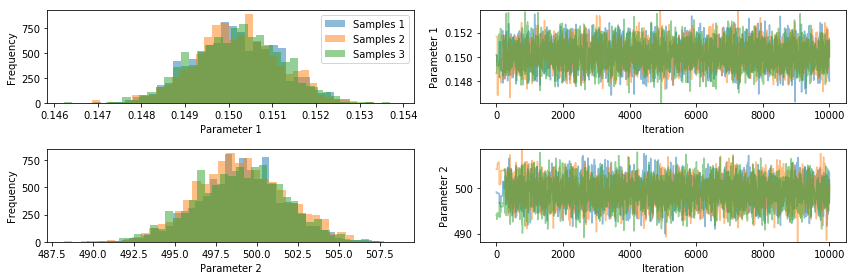

In [22]:
pints.plot.trace(emu_chains)
plt.show()

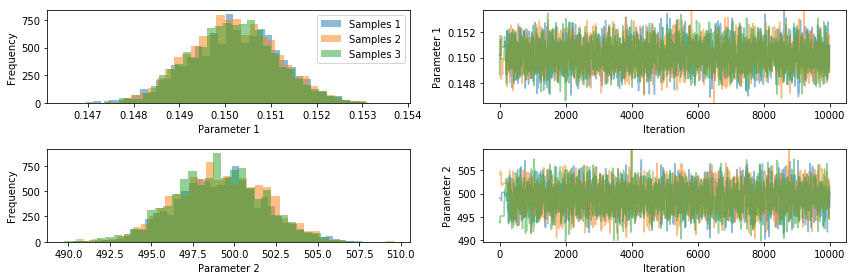

In [23]:
pints.plot.trace(real_chains)
plt.show()

# MCMC metrics

In [24]:
print('Emulator R-hat:')
print(pints.rhat_all_params(emu_chains))

Emulator R-hat:
[0.9999782900994769, 1.0000238693931143]


In [25]:
print('Real R-hat:')
print(pints.rhat_all_params(real_chains))

Real R-hat:
[1.0002694109857064, 1.0003993038615366]


In [26]:
# percentage
chain = real_chains[0]

chain_mape = emumet.chain_mape(chain, emu, log_likelihood)
print("Chain mean absolute percentage error: {:.5f}".format(chain_mape * 100))

Chain mean absolute percentage error: 0.00009


In [27]:
emu_mcmc_time = %timeit -o emu_mcmc.run()
print("Emulator MCMC time: {:.5f}".format(emu_mcmc_time.average))

19.9 s ± 1.38 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Emulator MCMC time: 19.87455


In [28]:
real_mcmc_time = %timeit -o real_mcmc.run()
print("MCMC time: {:.5f}".format(real_mcmc_time.average))

5.92 s ± 228 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MCMC time: 5.91545


In [29]:
emu_parameters, emu_parameters_std = emumet.estimate_parameters(emu_chains)
print("Emulator estimated parameters: ", emu_parameters)
print("Emulator parametet std: ", emu_parameters_std)

Emulator estimated parameters:  [1.50179011e-01 4.99033722e+02]
Emulator parametet std:  [1.8325112e-05 9.1623836e-02]


In [30]:
real_parameters, real_parameters_std = emumet.estimate_parameters(real_chains)
print("Real estimated parameters: ", real_parameters)
print("Real parameters std: ", real_parameters_std)

Real estimated parameters:  [1.50188219e-01 4.99094400e+02]
Real parameters std:  [2.16405816e-05 4.06376950e-02]


# Plotting emulator surfaces around parameters

In [31]:
# use smaller bounds to get an idea of the surface around real parameters
min_bounds = np.min(chain, axis = 0)
max_bounds = np.max(chain, axis = 0)
bounds = pints.RectangularBoundaries(min_bounds, max_bounds)

In [32]:
# plot surfaces
if n_parameters >=3:
    fixed_parameters = emutils.fix_parameters(bounds)
    
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        shape = (n_parameters, n_parameters - 1),
        contour = False,
        index_to_param_name=index_to_param_name,
        additional_log_likelihoods = [log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

In [33]:
print(bounds.lower())
print(bounds.upper())

[1.46953831e-01 4.90293490e+02]
[1.53584812e-01 5.07225477e+02]


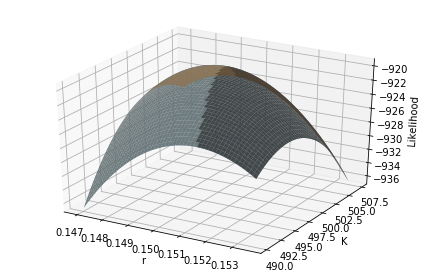

In [34]:
fig, ax = emuplt.plot_surface_fixed_param(
    emu,
    bounds,
    #fixed = [(1, 0.29)],
    index_to_param_name=index_to_param_name,
    contour=False,
    precision=2,
    additional_log_likelihoods=[log_likelihood]
)

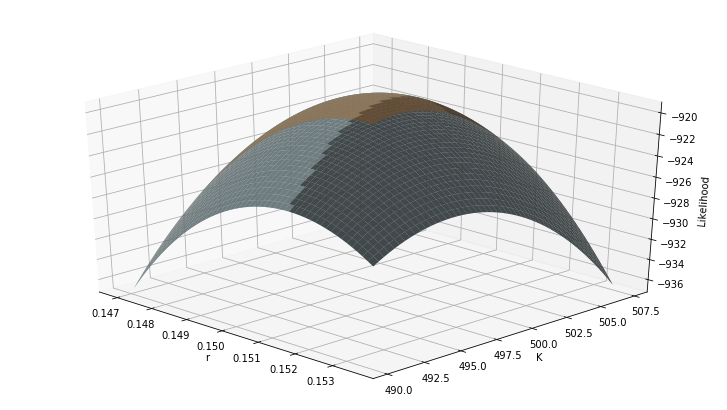

In [35]:
ax.view_init(30, 45 + 90 *3)
fig.set_size_inches(10.5, 6)
fig